# 数据表示与特征工程 

In [1]:
#导入相关模块
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn
%matplotlib inline

#忽略弹出的warnings
import warnings
warnings.filterwarnings('ignore')  
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## 分类变量处理

##### One-Hot编码(虚拟变量)

In [ ]:
#get_dummies方法
data_dummies = pd.get_dummies(data[drop_col]) #无序分类变量重编码
data.drop(drop_col,axis=1,inplace=True) #删除原始分类变量
data = pd.concat([data,data_dummies],axis=1) #表链接

## 分箱 离散化 线性模型与树

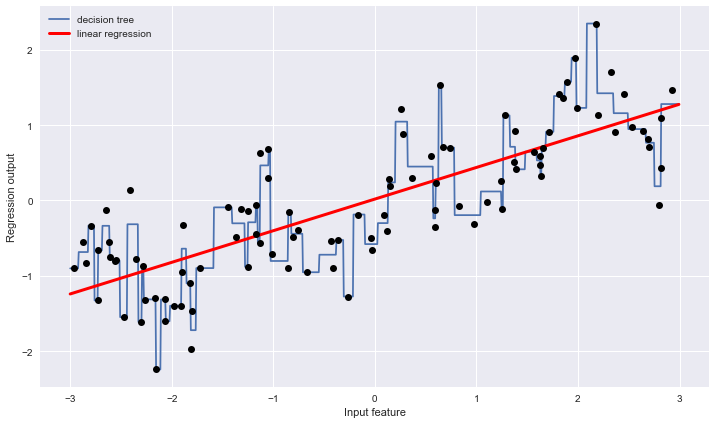

In [12]:
plt.figure(figsize=(12,7))
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X, y = mglearn.datasets.make_wave(n_samples=100)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)
reg = DecisionTreeRegressor(min_samples_split=3).fit(X, y)
plt.plot(line, reg.predict(line), label="decision tree")

reg = LinearRegression().fit(X, y)

plt.plot(line, reg.predict(line), label="linear regression",color="r",lw=3)

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

## 交互特征与多项式特征

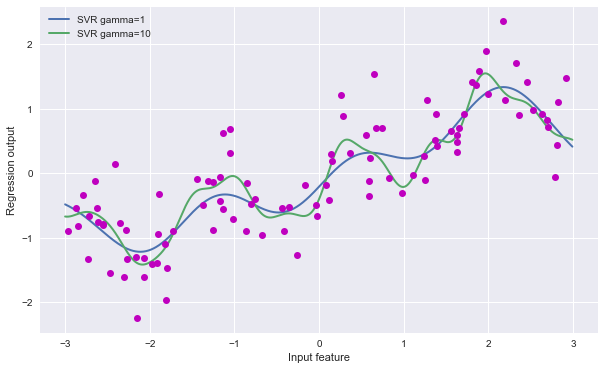

In [17]:
from sklearn.svm import SVR
plt.figure(figsize=(10,6))
for gamma in [1, 10]:
    svr = SVR(gamma=gamma).fit(X, y)
    plt.plot(line, svr.predict(line),lw=2, label='SVR gamma={}'.format(gamma))

plt.plot(X[:, 0], y, 'o', c='m')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

## 自动化特征选择
##### 变量选择的方法: 单变量统计, 基于模型的选择, 迭代选择

### 单体变量统计---方差分析

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]
原始数据 (284, 80)
经过方差分析后的数据 (284, 40)


<Figure size 720x288 with 0 Axes>

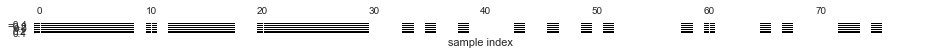

In [24]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()

#获得确定性的随机数
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data),50))#50个随机字段数据

#向数据中添加噪声特征
#前30个特征来自数据集,后50个是噪声
X_w_noise = np.hstack([cancer.data,noise])
x_train,x_test,y_train,y_test = train_test_split(X_w_noise,cancer.target,random_state=0,test_size=0.5)

#使用f_classif默认值和SelectPercentitle来选择30%的特征
select = SelectPercentile(percentile=50) 
select.fit(x_train,y_train)

#获取选择后的特征集
x_train_selected = select.transform(x_train)


#可视化结果
plt.figure(figsize=(10,4))
mask = select.get_support()
print(mask) #白色为False,黑色为True
plt.matshow(mask.reshape(1,-1),cmap="gray_r")
plt.xlabel("sample index")
print("原始数据",x_train.shape)
print("经过方差分析后的数据",x_train_selected.shape)

### 基于模型的特征选择

原始数据 (284, 80)
经过方差分析后的数据 (284, 40)


<Figure size 720x288 with 0 Axes>

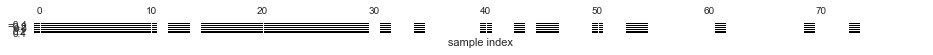

In [27]:
from sklearn.feature_selection import SelectFromModel #特征选择模型
from sklearn.ensemble import RandomForestClassifier #随机森林
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100,random_state=42),
                         threshold="median") #使用中位数作为阈值, 表示留下一半的特征

#训练分类器并筛选并输出数据集
select.fit(x_train,y_train)
x_train_l1 = select.transform(x_train)

#可视化结果
plt.figure(figsize=(10,4))
mask = select.get_support()
plt.matshow(mask.reshape(1,-1),cmap="gray_r")
plt.xlabel("sample index")
print("原始数据",x_train.shape)
print("经过方差分析后的数据",x_train_l1.shape)

### 迭代特征选择---递归特征消除法

原始数据 (284, 80)
经过方差分析后的数据 (284, 40)


<Figure size 720x288 with 0 Axes>

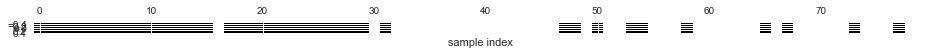

In [32]:
from sklearn.feature_selection import RFE #特征选择模型
from sklearn.ensemble import RandomForestClassifier #随机森林
select = RFE(
    RandomForestClassifier(n_estimators=100,random_state=42),
                         n_features_to_select=40) #留下一半的特征

#训练分类器并筛选并输出数据集
select.fit(x_train,y_train)
x_train_l2 = select.transform(x_train)

#可视化结果
plt.figure(figsize=(10,4))
mask = select.get_support()
plt.matshow(mask.reshape(1,-1),cmap="gray_r")
plt.xlabel("sample index")
print("原始数据",x_train.shape)
print("经过方差分析后的数据",x_train_l2.shape)

### 总结:
#### 单体变量主要考虑每一个变量与目标变量的关联性, 基于模型的特征选择根据特征对整个模型的权重选择, 递归消除法是逐一筛选